# Acoustic Event Detection

Acoustic event detection, or audio classification, is an important task in the audio processing community due to its wide applications. An acoustic event detection system receives a piece of audio as input, and generates a label represents the type of event in it, so it is typically defined as a multi-class classification problem.

Recent acoustic event detection systems (2017~) are mostly convolutional neural networks (CNNs), so we will implement and train a CNN here.

## 1. Data Preparation

You should already downloaded the data from the link provided in Courseworks. Unzip it to the same folder as this script, and perform data preparation as in HW1 & HW2. Systems for acoustic event detection typically take magnitude spectrograms as input, so you need to perform STFT on the waveforms. You can either perform normalization now or in the CNN model later (as in HW2).

The provided dataset contains 468 utterance, each 10 second long. 408 of them are used for training, 30 of them are used for validation, and 30 of them are used for testing. All audio are at 16k Hz sample rate. There are 15 different types of events:

In [1]:
import numpy as np
import librosa
import os
import time
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython.display import Audio

In [6]:
dir_path = 'AED_data'  # directory path

# load all event types
all_event = np.load(dir_path+'/event_types.npy')
print(all_event)

['beach' 'bus' 'cafe/restaurant' 'car' 'city_center' 'forest_path'
 'grocery_store' 'home' 'library' 'metro_station' 'office' 'park'
 'residential_area' 'train' 'tram']


A sample label looks like this:

In [7]:
# load labels for the training set
train_label = np.load(dir_path+'/train_labels.npy')
print(train_label[0])  # (label, audio_file) pair

['beach' 'b019_170_180.wav']


In [8]:
# listen to one example
y, _ = librosa.load(dir_path+'/audio/'+train_label[0][1], sr=16000)
Audio(y, rate=16000)

(257, 626)


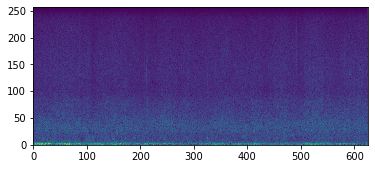

In [9]:
# plot the magnitude spectrogram

n_fft = 512
n_hop = 256

y_spec = librosa.stft(y, n_fft=n_fft, hop_length=n_hop)
y_spec_mag = np.abs(y_spec)
print(y_spec_mag.shape)
plt.imshow(y_spec_mag**.33, origin='lower')
plt.show()

Now it's your turn to load all data and perform any data preparation steps. You can directly borrow the scripts from HW1 & HW 2. Note that most acoustic event detection systems take magnitude spectrogram as input feature and predict a probability vector for all the event types, so you may want to perform proper feature extraction, normalization, and target label generation in your pipeline.

We will use the built-in [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) function in Pytorch for this task, so you don't need to generate one-hot labels here. Instead, you can set the index value of each of the events as the label. For example, *beach* corresponds to label *0* and *car* corresponds to label *3*.

In [29]:
# TODO: data preparation
# load labels for the validation set
train_label = np.load(dir_path+'/train_labels.npy')  # (label, audio_file) pair
validation_label = np.load(dir_path+'/validation_labels.npy')
# load labels for the test set
test_label = np.load(dir_path+'/test_labels.npy')
dir_aud=dir_path+'/audio'


train_n=[idd[1] for idd in train_label]
test_n=[idd[1] for idd in test_label]
validation_n=[idd[1] for idd in validation_label]

import h5py


# walk through the directory, find the files with .wav extension
wav_files = []
for (dirpath, dirnames, filenames) in os.walk(dir_aud):
    for file in filenames:
        if '.wav' in file:
            wav_files.append(dirpath+'/'+file)
        
num_data = len(wav_files)
print('Number of .wav files: {:2d}'.format(num_data))
print('Example path: ' + wav_files[0])


Number of .wav files: 468
Example path: AED_data/audio/a062_50_60.wav


In [32]:
wavename=wav_files[100][15:]
print(train_label[train_n.index(wavename)][0])
event=[idd for idd in all_event]
print(event)
print(event.index(train_label[train_n.index(wavename)][0]))
print(len(train_label))

NameError: name 'wav_files' is not defined

In [34]:
tr_name = 'tr_set.hdf5'
val_name = 'val_set.hdf5'
test_name = 'test_set.hdf5'

tr_dataset = h5py.File(tr_name, 'a')
val_dataset = h5py.File(val_name, 'a')
test_dataset = h5py.File(test_name, 'a')

# maximum length of waveforms 
sr = 16000  # sample rate
length_wave_max = 10 * sr

# STFT window and hop size
n_fft = 512
n_hop = n_fft // 4
tst_flag=0
trn_flag=0
val_flag=0
event=[idd for idd in all_event]

for i in range(num_data):
    wavename=wav_files[i][15:]
    
    # first 200 files for training, next 50 for validation, and last 69 for testing
    
    # load the wavefiles
    y, _ = librosa.load(wav_files[i], sr=sr)  # the default sample rate for them is 16kHz, but you can also change that
    
    # truncate or zero-pad the signal
    y = y[:length_wave_max]
    if len(y) < length_wave_max:
        y = np.concatenate([y, np.zeros(length_wave_max-len(y))])
    
    # calculate log-power spectrogram in decibel scale
    spec = librosa.stft(y, n_fft=n_fft, hop_length=n_hop)
    # the 1e-8 here is added for numerical stability, in case that log10(0) happens
    log_power_spec = 10*np.log10(np.abs(spec)**2 + 1e-8)  # shape: (n_fft/2+1, T)
    num_frame = log_power_spec.shape[1]  # this should be the same for all the utterances, since we map them into same length
    
    # save them into the hdf5 file
    
    if wavename in train_n:
        if trn_flag == 0:
            # create sub-datasets
            tr_dataset.create_dataset('waveform', shape=(len(train_label), length_wave_max), dtype=np.float32)
            tr_dataset.create_dataset('spec', shape=(len(train_label), n_fft//2+1, num_frame), dtype=np.float32)
            tr_dataset.create_dataset('label', shape=(len(train_label),), dtype=np.float32)
        
        tr_dataset['waveform'][trn_flag] = y
        tr_dataset['spec'][trn_flag] = log_power_spec
        tr_dataset['label'][trn_flag] =  event.index(train_label[train_n.index(wavename)][0])
        trn_flag=trn_flag+1
    elif wavename in validation_n:
        if val_flag == 0:
            # create sub-datasets
            val_dataset.create_dataset('waveform', shape=(len(validation_label), length_wave_max), dtype=np.float32)
            val_dataset.create_dataset('spec', shape=(len(validation_label), n_fft//2+1, num_frame), dtype=np.float32)
            val_dataset.create_dataset('label', shape=(len(validation_label),), dtype=np.float32)
        
        val_dataset['waveform'][val_flag] = y
        val_dataset['spec'][val_flag] = log_power_spec
        val_dataset['label'][val_flag] =  event.index(validation_label[validation_n.index(wavename)][0])
        val_flag=val_flag+1
    elif wavename in test_n:
        if tst_flag == 0:
            # create sub-datasets
            test_dataset.create_dataset('waveform', shape=(len(test_label), length_wave_max), dtype=np.float32)
            test_dataset.create_dataset('spec', shape=(len(test_label), n_fft//2+1, num_frame), dtype=np.float32)
            test_dataset.create_dataset('label', shape=(len(test_label),), dtype=np.float32)
        
        test_dataset['waveform'][tst_flag] = y
        test_dataset['spec'][tst_flag] = log_power_spec
        test_dataset['label'][tst_flag] =  event.index(test_label[test_n.index(wavename)][0])
        tst_flag=tst_flag+1
    else:
        print(' not found file in any of the sets')
    
tr_dataset.close()
val_dataset.close()
test_dataset.close()

In [35]:
# load the training set
tr_dataset = h5py.File(tr_name, 'a')
tr_spec = tr_dataset['spec']  # shape: (num_data, n_fft/2+1, T)
tr_spec = np.transpose(tr_spec[:], (0, 2, 1)).reshape(-1, n_fft//2+1)  # shape: (num_data*T, n_fft/2+1)
tr_mean = np.mean(tr_spec, axis=0)  # shape: (n_fft/2+1)
tr_var = np.var(tr_spec, axis=0)  # shape: (n_fft/2+1)
tr_std = np.sqrt(tr_var + 1e-8)  # again for numerical stability

# apply normalization to all the datasets

val_dataset = h5py.File(val_name, 'a')
test_dataset = h5py.File(test_name, 'a')

tr_dataset['spec'][:] = (tr_dataset['spec'][:] - tr_mean.reshape(1,-1,1)) / tr_std.reshape(1,-1,1)
val_dataset['spec'][:] = (val_dataset['spec'][:] - tr_mean.reshape(1,-1,1)) / tr_std.reshape(1,-1,1)
test_dataset['spec'][:] = (test_dataset['spec'][:] - tr_mean.reshape(1,-1,1)) / tr_std.reshape(1,-1,1)

tr_dataset.close()
val_dataset.close()
test_dataset.close()

# save the mean and std information in files
np.save('training_mean', tr_mean)
np.save('training_std', tr_std)

In [10]:
from torch.utils.data import Dataset, DataLoader

batch_size = 8

# a class to load the saved h5py dataset
class dataset_pipeline(Dataset):
    def __init__(self, path):
        super(dataset_pipeline, self).__init__()

        self.h5pyLoader = h5py.File(path, 'r')
        
        self.spec = self.h5pyLoader['spec']
        self.label=self.h5pyLoader['label']
        
        self._len = self.spec.shape[0]  # number of utterances
    
    def __getitem__(self, index):
        spec_item = torch.from_numpy(self.spec[index].astype(np.float32))
        label_item=self.label[index].astype(np.float32)
        #label_item = torch.from_numpy([self.label[index].astype(np.float32)])
        return spec_item, label_item
    
    def __len__(self):
        return self._len
    
# define data loaders
train_loader = DataLoader(dataset_pipeline('tr_set.hdf5'), 
                          batch_size=batch_size, 
                          shuffle=True,  # this ensures that the sequential order of the training samples will be shuffled for different training epochs
                         )

validation_loader = DataLoader(dataset_pipeline('val_set.hdf5'), 
                               batch_size=batch_size, 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )
test_loader = DataLoader(dataset_pipeline('test_set.hdf5'), 
                               batch_size=batch_size, 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )
dataset_len = len(train_loader)
log_step = dataset_len // 4
print(dataset_len)

51


In [11]:
for a in train_loader:
    b=a[0]
    b=b.unsqueeze(1)
    print(b.size())

torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size([8, 1, 257, 1251])
torch.Size

## 2. CNN architecture

Convolutional neural networks are the most popular network architecture in the past years. As our main focus is to apply CNN to the task of acoustic event detection, I will not go into the details of CNNs here, and for those of you who are not that familiar with it, this [online course](http://cs231n.stanford.edu/) can serve as a good reference. A CNN maps the input feature (the magnitude spectrogram in our case) into a vector representing the probability of different types of events. In our data where the input audio are all 10 second long, the CNN predicts a single label for the entire utterance.

[*torchvision*](https://pytorch.org/vision/stable/models.html#classification) contains a lot of pre-built model architectures and you don't need to build your own architecture here. You don't need to install this package as we need to make some modifications to the models.

We will use [AlexNet](https://en.wikipedia.org/wiki/AlexNet) here, the pioneer in the area of modern convolutional neural networks.
![ALexNet](https://neurohive.io/wp-content/uploads/2018/10/AlexNet-1.png)

An [example implementation](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html#alexnet) of AlexNet is already provided in *torchvision*, and we make several modifications here:
* The number of channels in the input is 1 instead of 3 (3 is for colored images with R/G/B channels)
* The number of channels in the hidden layers are decreased to save the model size and complexity

In [12]:
# borrow the implementation of AlexNet from https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html#alexnet

class AlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=11, stride=4, padding=2),  # number of input channel is 1 (for image it is 3) 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),  # we make the number of hidden channels smaller in these layers
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))  # perform adaptive mean pooling on any size of the input to match the provided size
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)  # the dimension after adaptive average pooling is (batch, 64, 3, 3)
        x = torch.flatten(x, 1)  # average
        x = self.classifier(x)
        return x
    
# test it with a sample input
model = AlexNet()
sample_input = torch.randn(2, 1, 257, 626)  # (batch_size, num_channel, freq_dim, time_step)
sample_output = model(sample_input)
print(sample_output)  # (batch_size, num_classes)

tensor([[ 0.0396, -0.0398,  0.0099,  0.0767, -0.0286,  0.0204,  0.0082, -0.0650,
         -0.0428,  0.0172,  0.0150,  0.0685, -0.0439,  0.0854, -0.0557],
        [ 0.0105, -0.0474,  0.0063,  0.0654, -0.0240,  0.0283,  0.0163, -0.0622,
         -0.0545,  0.0014,  0.0133,  0.0637, -0.0306,  0.0876, -0.0391]],
       grad_fn=<AddmmBackward>)


Note that the output layer in the code above does not contain a *Softmax* activation to generate probability distributions. This is mainly because the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) function combines the *Softmax* function and the *logarithm* function for better numerical stability, so during training you can simply use the built-in *nn.CrossEntropyLoss* as the training objective. In the test phase where you need to determine the only label assigned to each utterance, you can simply perform *argmax* on the output of the model to get the corresponding label (remember that *Softmax* is a continuous relaxation of *argmax*).

Now we can train AlexNet on the task of audio event detection, and evaluate the trained model on the test set above. You should report the overall accuracy on the 30 **test** utterances and the independent accuracy for each of the 15 event types. You need to achieve at least 60% overall accuracy on the **validation** set to get the full mark.

In [17]:
def Accuracy(prediction, label):
    """
    BCE between the predicted probabilities and the target labels.
    args:
        prediction: shape (num_frame,), torch tensor
        label: shape (num_frame,), torch tensor
    output:
        acc_value: float, a single value, a percentage value between 0 and 100 (corresponds to 0% and 100% accuracy)
    """
    batch_size = prediction.shape[0]

    acc_value= 1.0*(prediction==label)
    acc_value=acc_value.mean()*100
            
    return acc_value

In [23]:
a=np.array([2,3,0,4,5,1,2,3,4])
b=np.array([2,3,1,4,5,1,2,3,4])

print(Accuracy(b,a))
print(b,a)


88.88888888888889
[2 3 1 4 5 1 2 3 4] [2 3 0 4 5 1 2 3 4]


In [26]:
# TODO: train the model on the dataset above
lossF = nn.CrossEntropyLoss()
def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode. Always do this before you start training!
    train_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(train_loader):
        batch_Sp = data[0].unsqueeze(1)
        batch_label= data[1]
        
        # clean up the gradients in the optimizer
        # this should be called for each batch
        optimizer.zero_grad()
        
        output= model(batch_Sp)
        #output=torch.argmax(output,dim=1)
        
        #print('o', output.shape)
        # MSE as objective
        #print('l',batch_label.shape)
        loss = lossF(output, batch_label.long())
        
        # automatically calculate the backward pass
        loss.sum().backward()
        # perform the actual backpropagation
        optimizer.step()
        
        train_loss += loss.sum().data.item()
        
        # OPTIONAL: you can print the training progress 
        if versatile:
            if (batch_idx+1) % log_step == 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | BCE {:5.4f} |'.format(
                    epoch, batch_idx+1, len(train_loader),
                    elapsed * 1000 / (batch_idx+1), 
                    train_loss / (batch_idx+1)
                    ))
    
    train_loss /= (batch_idx+1)
    print('-' * 99)
    print('    | end of training epoch {:3d} | time: {:5.2f}s | BCE {:5.4f} |'.format(
            epoch, (time.time() - start_time), train_loss))
    
    return train_loss
        
def validate(model, epoch):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode. Always do this during validation or test phase!
    validation_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(validation_loader):
        batch_Sp = data[0].unsqueeze(1)
        batch_label= data[1]
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
        with torch.no_grad():
        
            output= model(batch_Sp)
            output=torch.argmax(output,dim=1)

            #print('o', output.shape)
            # MSE as objective
            #print('l',batch_label.shape)
            loss = Accuracy(output, batch_label.long())
        
            validation_loss += loss.data.item()
    
    validation_loss /= (batch_idx+1)
    print('    | end of validation epoch {:3d} | time: {:5.2f}s | accs {:5.4f} |'.format(
            epoch, (time.time() - start_time), validation_loss))
    print('-' * 99)
    
    return validation_loss


In [86]:
total_epoch = 60  # train the model for 100 epochs
model_save = 'best_model_AED.pt'  # path to save the best validation model

# main function

training_loss = []
validation_loss = []

model_AN = AlexNet()
optimizer = optim.Adam(model_AN.parameters(), lr=1e-3)
for epoch in range(1, total_epoch + 1):
    training_loss.append(train(model_AN , epoch))
    validation_loss.append(validate(model_AN, epoch))
    if training_loss[-1] == np.min(training_loss):
        print('      Best training model found.')
    if validation_loss[-1] == np.max(validation_loss):
        # save current best model on validation set
        with open(model_save, 'wb') as f:
            torch.save(model_AN.state_dict(), f)
            print('      Best validation model found and saved.')
    
    print('-' * 99)

| epoch   1 |    12/   51 batches | ms/batch 305.36 | BCE 2.7070 |
| epoch   1 |    24/   51 batches | ms/batch 299.02 | BCE 2.6814 |
| epoch   1 |    36/   51 batches | ms/batch 298.34 | BCE 2.6304 |
| epoch   1 |    48/   51 batches | ms/batch 296.51 | BCE 2.6216 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 15.12s | BCE 2.6168 |
    | end of validation epoch   1 | time:  0.28s | accs 12.5000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch   2 |    12/   51 batches | ms/batch 308.94 | BCE 2.5222 |
| epoch   2 |    24/   51 batches | ms/batch 302.06 | BCE 2.4864 |
| epoch   2 |    36/   51 batches | ms/batch 303.43 | BCE 2.5025 |
| epoch   2 |    48/   51

| epoch  12 |    12/   51 batches | ms/batch 359.93 | BCE 1.8605 |
| epoch  12 |    24/   51 batches | ms/batch 375.98 | BCE 1.8873 |
| epoch  12 |    36/   51 batches | ms/batch 389.19 | BCE 1.8332 |
| epoch  12 |    48/   51 batches | ms/batch 396.01 | BCE 1.8224 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  12 | time: 20.27s | BCE 1.8146 |
    | end of validation epoch  12 | time:  0.40s | accs 19.7917 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
| epoch  13 |    12/   51 batches | ms/batch 424.78 | BCE 1.7280 |
| epoch  13 |    24/   51 batches | ms/batch 431.76 | BCE 1.7561 |
| epoch  13 |    36/   51 batches | ms/batch 437.41 | BCE 1.7626 |
| epoch  13 |    48/   51 batches | ms/batch 445.71 | BCE 1.7569 |
---

| epoch  23 |    24/   51 batches | ms/batch 331.83 | BCE 1.4839 |
| epoch  23 |    36/   51 batches | ms/batch 331.55 | BCE 1.4163 |
| epoch  23 |    48/   51 batches | ms/batch 331.74 | BCE 1.3928 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  23 | time: 16.93s | BCE 1.3947 |
    | end of validation epoch  23 | time:  0.31s | accs 44.7917 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  24 |    12/   51 batches | ms/batch 330.40 | BCE 1.3508 |
| epoch  24 |    24/   51 batches | ms/batch 332.28 | BCE 1.3950 |
| epoch  24 |    36/   51 batches | ms/batch 334.61 | BCE 1.3357 |
| epoch  24 |    48/   51 batches | ms/batch 336.45 | BCE 1.2942 |
---------------------------------------------------------------------------------------------------
   

    | end of validation epoch  34 | time:  0.36s | accs 52.0833 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  35 |    12/   51 batches | ms/batch 382.12 | BCE 0.8602 |
| epoch  35 |    24/   51 batches | ms/batch 378.21 | BCE 0.9798 |
| epoch  35 |    36/   51 batches | ms/batch 366.62 | BCE 0.9281 |
| epoch  35 |    48/   51 batches | ms/batch 357.43 | BCE 0.8935 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  35 | time: 18.15s | BCE 0.8825 |
    | end of validation epoch  35 | time:  0.31s | accs 58.3333 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
------------------------------------------------------------

| epoch  46 |    12/   51 batches | ms/batch 356.36 | BCE 0.5355 |
| epoch  46 |    24/   51 batches | ms/batch 347.76 | BCE 0.6084 |
| epoch  46 |    36/   51 batches | ms/batch 343.00 | BCE 0.6355 |
| epoch  46 |    48/   51 batches | ms/batch 340.40 | BCE 0.6387 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  46 | time: 17.32s | BCE 0.6342 |
    | end of validation epoch  46 | time:  0.30s | accs 61.4583 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
| epoch  47 |    12/   51 batches | ms/batch 320.61 | BCE 0.4758 |
| epoch  47 |    24/   51 batches | ms/batch 318.79 | BCE 0.5349 |
| epoch  47 |    36/   51 batches | ms/batch 316.89 | BCE 0.5954 |
| epoch  47 |    48/   51 batches | ms/batch 315.99 | BCE 0.7173 |
---

---------------------------------------------------------------------------------------------------
    | end of training epoch  57 | time: 16.46s | BCE 0.4663 |
    | end of validation epoch  57 | time:  0.30s | accs 67.7083 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  58 |    12/   51 batches | ms/batch 319.52 | BCE 0.3795 |
| epoch  58 |    24/   51 batches | ms/batch 316.53 | BCE 0.3482 |
| epoch  58 |    36/   51 batches | ms/batch 315.46 | BCE 0.4176 |
| epoch  58 |    48/   51 batches | ms/batch 314.71 | BCE 0.4607 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  58 | time: 16.05s | BCE 0.4611 |
    | end of validation epoch  58 | time:  0.29s | accs 61.4583 

In [87]:
# TODO: evaluate your best model on the test set

model_AED=AlexNet()
model_AED.load_state_dict(torch.load('best_model_AED.pt'))
test_loss=0
for batch_idx, data in enumerate(test_loader):
    
    batch_Sp = data[0].unsqueeze(1)
    batch_label= data[1]
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
    with torch.no_grad():

        output= model_AED(batch_Sp)
        output=torch.argmax(output,dim=1)

        #print('o', output.shape)
        # MSE as objective
        #print('l',batch_label.shape)
        loss = Accuracy(output, batch_label.long())

        test_loss += loss.data.item()
    
test_loss /= (batch_idx+1)
print('    | end of test |  test_accs: ', test_loss)



    | end of test |  test_accs:  87.74510192871094


In [88]:
event=[idd for idd in all_event]

In [89]:
# since the test has only 30 samples we calculate the individual category accouracy on the training set:
tr_loadern = DataLoader(dataset_pipeline('tr_set.hdf5'), 
                               batch_size=len(train_label), 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )
def AccuracyI(prediction, label,i):
    """
    BCE between the predicted probabilities and the target labels.
    args:
        prediction: shape (num_frame,), torch tensor
        label: shape (num_frame,), torch tensor
    output:
        acc_value: float, a single value, a percentage value between 0 and 100 (corresponds to 0% and 100% accuracy)
    """
    batch_size = prediction.shape[0]
    correct=[ 1*(prediction[idx]==i) for idx, idd in enumerate(label) if idd==i]
    
    #acc_value= 1.0*(prediction==label and label==i)
    acc_value=np.mean(correct)*100
            
    return acc_value
accI=[]
for i in range(len(event)):
    test_loss=0;
    for batch_idx, data in enumerate(tr_loadern):
        batch_Sp = data[0].unsqueeze(1)
        batch_label= data[1]

            # you don't need to calculate the backward pass and the gradients during validation
            # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
        with torch.no_grad():

            output= model_AED(batch_Sp)
            output=torch.argmax(output,dim=1)
            #print('o', output.shape)
            # MSE as objective
            #print('l',batch_label.shape)
            loss = AccuracyI(output.cpu().detach().numpy(), batch_label,i)

            test_loss += loss
    
    test_loss /= (batch_idx+1)
    accI.append(test_loss)

In [90]:
print(accI)
idds=sorted(range(len(accI)), key=lambda k: accI[k])
print( [event[idd] for idd in idds])

[96.66666666666667, 78.57142857142857, 50.0, 93.75, 93.10344827586206, 100.0, 86.36363636363636, 75.0, 76.92307692307693, 88.88888888888889, 96.29629629629629, 81.81818181818183, 96.66666666666667, 54.54545454545454, 73.33333333333333]
['cafe/restaurant', 'train', 'tram', 'home', 'library', 'bus', 'park', 'grocery_store', 'metro_station', 'city_center', 'car', 'office', 'beach', 'residential_area', 'forest_path']


Find the type of events that has the lowest accuracy, listen to it and plot their spectrograms. Also find out the model prediction - what kind of event does the model misclassify? What are the top 3 predicted event types from the model? What can you learn from the outputs?

(257, 626)


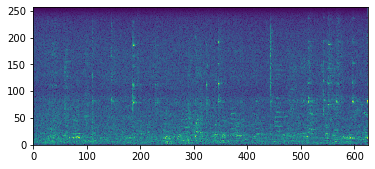

In [92]:
# TODO: enter your observation and discussion here
'''
['cafe/restaurant', 'train', 'tram', 'home', 'library', 'bus', 'park', 'grocery_store', 'metro_station', 'city_center', 'car', 'office', 'beach', 'residential_area', 'forest_path']
events in order of the worst classification accuracy to the best are listed as above. 
Sounds that are a mix of other sounds are harder to classify. and occupy most frequencies and don't have a defined freq

'''
train_n=[idd[1] for idd in train_label]
train_typ=[idd[0] for idd in train_label]
# listen to one example
y, _ = librosa.load(dir_path+'/audio/'+train_label[train_typ.index('cafe/restaurant')][1], sr=16000)
Audio(y, rate=16000)


n_fft = 512
n_hop = 256

y_spec = librosa.stft(y, n_fft=n_fft, hop_length=n_hop)
y_spec_mag = np.abs(y_spec)
print(y_spec_mag.shape)
plt.imshow(y_spec_mag**.33, origin='lower')
plt.show()
Audio(y, rate=16000)

## Discussion: evaluation metric

We are simply using the accuracy as the evaluation metric. Other widely used metrics for classification task, such as *mean average precision (mAP)*, *precision/recall/F1 scores*, and *area-under-curve (AUC)* can also be used. You can check [this page](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for different types of metrics, and check [this repository](https://github.com/qiuqiangkong/sound_event_detection_dcase2017_task4/blob/master/utils/calculate_metrics.py) for their usage.